# StroopActFlow -- Computational Model -- Single Subject

## Goal: Try to model non-linear FC processes by estimating and extracting out the B0 term from multiple linear regression
### Idea: Using a chaotic dynamical model with a non-linearity (e.g., tanh, sigmoid, rectified linear unit) we can extract the bias term in the model for each node by estimating the B0 from multiple linear regression

#### Taku Ito
#### 01/31/2017

### Generate a simple model with no network structure with all excitatory connections


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import sys
import fc
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages


# 0.0 Set up network
## 0.1 Construct artificial structural matrix

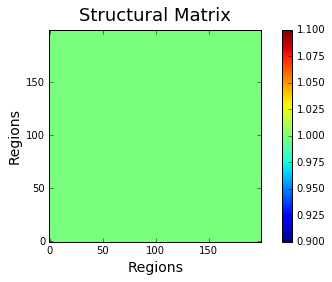

In [6]:
# Number of communities
ncommunities = 1
innetwork_dsity = 1
outnetwork_dsity = 1
hubnetwork_dsity = 1

nodespernetwork = 200
totalnodes = nodespernetwork * ncommunities

Wee = np.zeros((totalnodes,totalnodes))
# Construct structural matrix
nodecount = 0
for i in range(ncommunities):
    for j in range(ncommunities):
        for node in range(nodespernetwork):
            # Set within network community connections
            if i==j:
                tmp_a = np.random.rand(nodespernetwork,nodespernetwork)<innetwork_dsity
                indstart = i*nodespernetwork
                indend = i*nodespernetwork+nodespernetwork
                # Make connections lognormal
                Wee[indstart:indend,indstart:indend] = tmp_a
            else:
                tmp_b = np.random.rand(nodespernetwork,nodespernetwork)<outnetwork_dsity
                indstart_i = i*nodespernetwork
                indend_i = i*nodespernetwork + nodespernetwork
                indstart_j = j*nodespernetwork
                indend_j = j*nodespernetwork + nodespernetwork
                Wee[indstart_i:indend_i, indstart_j:indend_j] = tmp_b
                # Make symmetric across diagonal
#                 Wee[indstart_j:indend_j, indstart_i:indend_i] = tmp_b.T
                
# Redo a community to force it like a hub
hubnetwork = 0
for i in range(ncommunities):
    for j in range(ncommunities):
        if (i==hubnetwork or j==hubnetwork) and i!=j:
            tmp_b = np.random.rand(nodespernetwork,nodespernetwork)<hubnetwork_dsity
            indstart_i = i*nodespernetwork
            indend_i = i*nodespernetwork + nodespernetwork
            indstart_j = j*nodespernetwork
            indend_j = j*nodespernetwork + nodespernetwork
            Wee[indstart_i:indend_i, indstart_j:indend_j] = tmp_b
            # Make symmetric across diagonal
#             Wee[indstart_j:indend_j, indstart_i:indend_i] = tmp_b.T
        
# Make sure self-connections exist
np.fill_diagonal(Wee, 1)

fig = plt.figure()
plt.imshow(Wee, origin='lower')
plt.title('Structural Matrix', y=1.02, fontsize=18)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions',fontsize=14)
plt.tight_layout()
plt.colorbar()


## 0.2 Add Gaussian synaptic weights centered around 0

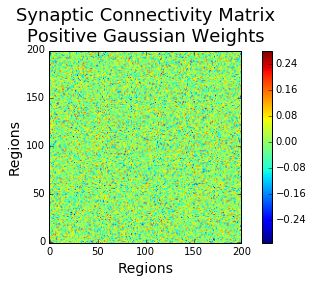

In [7]:
# Find non-zero connections
Gee = np.zeros((Wee.shape))
# triu = np.triu_indices(totalnodes,k=0)
connect_ind = np.where(Wee!=0)
nconnects = len(connect_ind[0])
# weights = np.random.lognormal(mean=1.0-np.log(0.2), sigma=1.0, size=(nconnects,))
weights = np.random.normal(loc=0.0,scale=1.0/np.sqrt(totalnodes), size=(nconnects,))
Gee[connect_ind] = weights
# Gee[triu] = Wee[triu] * weights[triu]
# Now force lower triangle to have same weights
# Gee = Gee + Gee.T
# Now divide diagonal by 2, since it was added twice
# diag_ind = np.diag_indices(totalnodes)
# Gee[diag_ind] = Gee[diag_ind]/2.0

# Gee = Gee/np.sqrt(totalnodes)

# To avoid unrealistic connectivity strengths as in Teramae 2012 paper, let no Gee > 20
# while np.sum(Gee>20) > 0:
#     # Find where these synapses are
#     ind = np.where(Gee>20)
#     xrows = len(ind[0])
#     rand = np.random.randn(xrows,)
#     Gee[ind] = rand

fig = plt.figure()
plt.imshow(Gee, origin='lower')#, vmin=0, vmax=20)
plt.colorbar()
plt.title('Synaptic Connectivity Matrix\nPositive Gaussian Weights', y=1.02, fontsize=18)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions',fontsize=14)
plt.tight_layout()

np.fill_diagonal(Gee,0)


# 1.0 The model

$$ \frac{dx_{i}}{dt} \tau_{i} = -x_{i}(t) + \hspace{1 pt} \phi \bigg{(} g \sum_{j\neq i}^{N} \big{(} w_{ij} \hspace{1 pt} x_{j}(t) \big{)} + s  \hspace{2 pt} x_i(t) + b_{i} \bigg{)} $$


where $x_i$ is the activity of region $i$, $\tau_{i}$ is the time constant for region $i$, $s$ is the recurrent (local) coupling, $g$ is the global coupling parameter, $\phi$ is the bounded transfer function (in this scenario is the hyperbolic tangent), $W_{xy}$ is the synaptic connectivity matrix, and $I$ is the task-stimulation (if any).

## 1.1 Define simulation function and associated functions
* relu function
* hrf and convolution functions

### 1.1.1 - rectified linear unit function

In [8]:
def relu(x):
    """rectified linear unit"""
    ind = np.where(x<0)[0]
    x[ind] = 0
    return x

### 1.1.2 - network model simulation

In [9]:
def networkModel(Gee,Tmax=100,dt=.1,g=3.0,s=1.0,tau=10.0,I=None, noise=None, bias=None, transfer='sigmoid', showplot=True):
    """
    Tmax = 100      (1sec / 1000ms)
    dt = .1         (1ms)
    g = 3.0         Coupling 
    s = 1.0         Self connection
    tau = 1.0       Time constant 
    I = 0.0         Stimulation/Task
    
    
    """
    T = np.arange(0, Tmax, dt)

    # Select bias for each node
    if bias == None:
        bias = np.zeros((totalnodes,))
    
    # Select transfer function
    if transfer=='tanh':
        phi = lambda x: np.tanh(x)
    elif transfer=='sigmoid':
        phi = lambda x: 2/(1+np.exp(-2*x))
    elif transfer=='relu':
        def relu(x):
            """rectified linear unit"""
            ind = np.where(x<0)[0]
            x[ind] = 0
            return x
        phi = relu
    
    # External input (or task-evoked input) && noise input
    if I==None: I = np.zeros((totalnodes,len(T)))
    # Noise parameter
    if noise == None: 
        noise = np.zeros((totalnodes,len(T)))
    else: 
        noise = np.random.normal(size=(totalnodes,len(T)))/noise

    # Initial conditions and empty arrays
    Enodes = np.zeros((totalnodes,len(T)))
    # Initial conditions
    Einit = np.random.rand(totalnodes,)
    Enodes[:,0] = Einit

#     spont_act = np.zeros((totalnodes,))
    for t in range(len(T)-1):

        ## Solve using Runge-Kutta Order 2 Method
        # With auto-correlation
#         spont_act = (noise[:,t] + I[:,t])
        k1e = -Enodes[:,t] + phi(g*np.dot(Gee,Enodes[:,t]) + s*Enodes[:,t] + bias)
#         k1e += spont_act
        k1e = k1e/tau
        #   
        ave = Enodes[:,t] + k1e*dt
        #   
        # With auto-correlation
#         spont_act = (noise[:,t+1] + I[:,t+1])
        k2e = -ave + phi(g*np.dot(Gee,ave) + s*ave + bias)
#         k2e += spont_act # Local processing
        k2e = k2e/tau

        Enodes[:,t+1] = Enodes[:,t] + (.5*(k1e+k2e))*dt

    if showplot:
        plt.figure()
        plt.imshow(Enodes[:,:1000], origin='lower')
        plt.title('Activity\ng='+str(g)+' ; s='+str(s))
        plt.ylabel('Regions')
        plt.xlabel('Time')
        plt.colorbar()

#         plt.figure()
#         plt.title('Activity of Sample Regions')
#         for i in range(4):
#             n = i
#             plt.plot(Enodes[n,:1000], label='Region' + str(i))
#         plt.legend(loc=(1.08,.5))
        
    return Enodes, bias

### 1.1.3 -  HRF function

In [10]:
from scipy.stats import gamma

def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6.0)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12.0)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

### 1.1.4 HRF convolution function

In [11]:
def convolveTimeseries(timeseries, samplingrate=1.0, TRLength=100):
    """
    Convolve the timeseries with a hemodynamic response function
    Also downsample the timeseries to an appropriate fMRI sampling rate
    Default sampling rate = 1.0 (10ms)
    Default TRLength = 100 (1 second)
    """

    simsample_rate=samplingrate
    simsample_times = np.arange(0, 30, simsample_rate, dtype=float)
    hrf_at_simsample = hrf(simsample_times)

    # Convolve simulated time series with HRF
    nregions = timeseries.shape[0]
    timeseries_convolved=np.ones(np.shape(timeseries),dtype=float)
    for region in range(nregions):
        convolved = np.convolve(timeseries[region,:], hrf_at_simsample)
        n_to_remove = len(hrf_at_simsample) - 1
        convolved = convolved[:-n_to_remove]
        timeseries_convolved[region,:]=convolved

    # Downsample fMRI time series
    TR=TRLength
    dt_rec=samplingrate
    n_skip_BOLD = int(TR/dt_rec)
    BOLD_rec = timeseries_convolved[:,::n_skip_BOLD]

    return BOLD_rec, timeseries_convolved

## 2.0 Run parameter sweep -- see how different regression fits perform with different model parameters (i.e., g & s)
##### Using a chaotic network model with transfer function = tanh

### 2.1 Define function for parameter sweep

In [14]:
def generateChaosAndRegressionFit(Gee, bias, g=10.0, s=1.0, model='tanh', Tmaxrest=10000, printresults=False):
    
    # Instantiate task data dictionary
    taskdata = {}

    # Simulation parameters
#     Tmaxrest = 10000 # 500 seconds
    dt = 1.0 # Sampled @ 10ms
    T = np.arange(0,Tmaxrest,dt)
    
    # Set bias
    # bias = np.random.randint(-5,5,size=(totalnodes,))
    
    # Run dynamics
    restdata, restbias = networkModel(Gee=Gee,Tmax=Tmaxrest,dt=dt,
                                      g=g,s=s,tau=1.0, transfer='tanh', bias=bias, showplot=False)

#     # Simulate hemodynamics
#     out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
#     plt.figure()
#     plt.title('Resting-state activity of sample regions convolved with HRF')
#     for i in range(5):
#         n = i 
#         plt.plot(out1[n,:], label='Network' + str(i))
#     plt.legend(loc=(1.08,.5))
#     plt.ylabel('Activity')
#     plt.xlabel('Time (s)')
    
    ## Model regression fit (tanh model)
    fc_multreg, rsquared = fc.tanhFC(restdata)
    modelfit_mean = np.mean(rsquared)
    modelfit_std = np.std(rsquared)
    
    B0_multreg = np.diag(fc_multreg)
    b0tobias = stats.pearsonr(restbias,B0_multreg)
    r_b0tobias, p_b0tobias = b0tobias

    fc2ic = stats.pearsonr(np.reshape(fc_multreg,-1), np.reshape(Gee,-1))
    r_fc2ic, p_fc2ic = fc2ic
    if printresults:
        print 'Mean r-squared fit', modelfit_mean
        print 'Std r-squared fit', modelfit_std
        print '\nPearson-r of B0s pre-convolved with biases:', r_b0tobias, '; p =' , p_b0tobias
        print '\nFit to intrinsic connectivity r =', r_fc2ic, '; p =', p_fc2ic
    
    return restdata, fc_multreg, modelfit_mean, modelfit_std, b0tobias, fc2ic

### 2.2 Run parameter search
##### Run g = [2...30] in increments of 1
##### Fix s = 1.0

In [15]:
bias = np.random.normal(size=(totalnodes,))
gmin = 2.0
gmax = 31.0
gstep = 1.0
s = 1.0

paramsearch = {}
for g in np.arange(gmin,gmax,gstep):
    print '***********************'
    print 'Simulation for g =', g, '; s =', s
        
    out = generateChaosAndRegressionFit(Gee, bias, g=g, s=s, printresults=False)
    
#     print '\n\n'

    # results dict
    paramsearch[g] = {}
    paramsearch[g]['restdata'] = out[0]
    paramsearch[g]['fc_multreg'] = out[1]
    paramsearch[g]['modelfit_mean'] = out[2]
    paramsearch[g]['modelfit_std'] = out[3]
    paramsearch[g]['b0tobias'] = out[4]
    paramsearch[g]['fc2ic'] = out[5]
    


***********************
Simulation for g = 2.0 ; s = 1.0
***********************
Simulation for g = 3.0 ; s = 1.0
***********************
Simulation for g = 4.0 ; s = 1.0
***********************
Simulation for g = 5.0 ; s = 1.0
***********************
Simulation for g = 6.0 ; s = 1.0
***********************
Simulation for g = 7.0 ; s = 1.0
***********************
Simulation for g = 8.0 ; s = 1.0
***********************
Simulation for g = 9.0 ; s = 1.0
***********************
Simulation for g = 10.0 ; s = 1.0
***********************
Simulation for g = 11.0 ; s = 1.0
***********************
Simulation for g = 12.0 ; s = 1.0
***********************
Simulation for g = 13.0 ; s = 1.0
***********************
Simulation for g = 14.0 ; s = 1.0
***********************
Simulation for g = 15.0 ; s = 1.0
***********************
Simulation for g = 16.0 ; s = 1.0
***********************
Simulation for g = 17.0 ; s = 1.0
***********************
Simulation for g = 18.0 ; s = 1.0
**********************

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### 2.3 Now compute some statistics on how regression fit the chaotic model
##### Using arctanh transform on observed variables, i.e., Generalized Linear Model with arctanh link func

In [16]:
g_arr = np.arange(gmin,gmax,gstep)

modelfit = {}
modelfit['mean'] = []
modelfit['std'] = []
b0tobias_fit = []
fc2ic_fit = []
for g in g_arr:
    modelfit['mean'].append(paramsearch[g]['modelfit_mean'])
    modelfit['std'].append(paramsearch[g]['modelfit_std'])
    b0tobias_fit.append(paramsearch[g]['b0tobias'][0]) # First element of tuple is r; second is p-val
    fc2ic_fit.append(paramsearch[g]['fc2ic'][0])

Network has 200 nodes
10000 timepoints simulated
Transfer function of dynamical model: tanh
Generalized Linear Regression using tanh fit (arctanh transform on y-var)


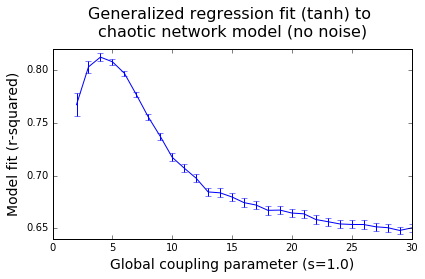

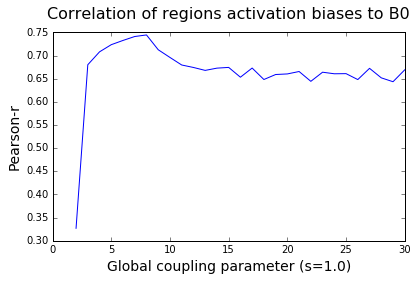

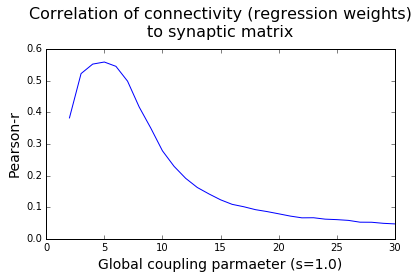

In [21]:
Tmaxrest=10000
print 'Network has', totalnodes, 'nodes'
print Tmaxrest, 'timepoints simulated'
print 'Transfer function of dynamical model: tanh'
print 'Generalized Linear Regression using tanh fit (arctanh transform on y-var)'

plt.figure()
plt.title('Generalized regression fit (tanh) to \nchaotic network model (no noise)',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parameter (s=1.0)', fontsize=14)
plt.ylabel('Model fit (r-squared)', fontsize=14)
ste = modelfit['std']/np.sqrt(totalnodes)
plt.errorbar(g_arr,modelfit['mean'], yerr=ste) # Standard error
plt.tight_layout()
plt.savefig('GeneralizedRegressionFit_tanhGLM_ToChaoticNetwork_gParamSweep.pdf')

plt.figure()
plt.title('Correlation of regions'' activation biases to B0',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parameter (s=1.0)', fontsize=14)
plt.ylabel('Pearson-r', fontsize=14)
plt.plot(g_arr,b0tobias_fit)
plt.tight_layout()
plt.savefig('CorrBetweenBiases2B0_tanhGLM_gParamSweep.pdf')

plt.figure()
plt.title('Correlation of connectivity (regression weights)\nto synaptic matrix',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parmaeter (s=1.0)', fontsize=14)
plt.ylabel('Pearson-r', fontsize=14)
plt.plot(g_arr,fc2ic_fit)
plt.tight_layout()
plt.savefig('CorrOfEstimatedFCAndSynapticNetwork_tanhGLM_gParamSweep.pdf')


### 2.4 Compare with Linear Regression Model Fit

In [25]:
# g_arr = np.arange(gmin,gmax,gstep)

paramsearch_linreg = {}
for g in g_arr:
    paramsearch_linreg[g] = {}
    print g
    ## Model regression fit (tanh model)
    fc_multreg, rsquared = fc.multregressionconnectivity(paramsearch[g]['restdata'])
    modelfit_mean = np.mean(rsquared)
    modelfit_std = np.std(rsquared)
    
    B0_multreg = np.diag(fc_multreg)
    b0tobias = stats.pearsonr(bias,B0_multreg)
    r_b0tobias, p_b0tobias = b0tobias

    fc2ic = stats.pearsonr(np.reshape(fc_multreg,-1), np.reshape(Gee,-1))
    r_fc2ic, p_fc2ic = fc2ic
    
    paramsearch_linreg[g]['fc_multreg'] = fc_multreg
    paramsearch_linreg[g]['modelfit_mean'] = modelfit_mean
    paramsearch_linreg[g]['modelfit_std'] = modelfit_std
    paramsearch_linreg[g]['b0tobias'] = b0tobias
    paramsearch_linreg[g]['fc2ic'] = fc2ic

    

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0


#### Set up for plotting

In [26]:
g_arr = np.arange(gmin,gmax,gstep)

modelfit_linreg = {}
modelfit_linreg['mean'] = []
modelfit_linreg['std'] = []
b0tobias_linfit = []
fc2ic_linfit = []
for g in g_arr:
    modelfit_linreg['mean'].append(paramsearch_linreg[g]['modelfit_mean'])
    modelfit_linreg['std'].append(paramsearch_linreg[g]['modelfit_std'])
    b0tobias_linfit.append(paramsearch_linreg[g]['b0tobias'][0]) # First element of tuple is r; second is p-val
    fc2ic_linfit.append(paramsearch_linreg[g]['fc2ic'][0])

Network has 200 nodes
10000 timepoints simulated
Transfer function of dynamical model: tanh
Generalized Linear Regression using identity fit (regular GLM)


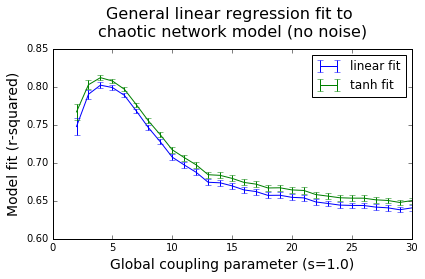

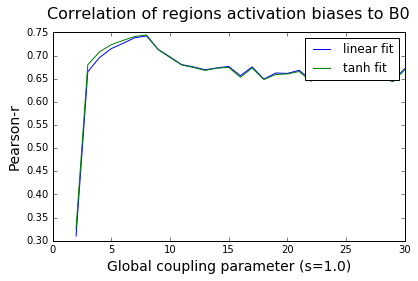

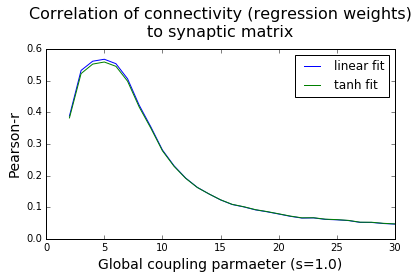

In [34]:
print 'Network has', totalnodes, 'nodes'
print Tmaxrest, 'timepoints simulated'
print 'Transfer function of dynamical model: tanh'
print 'Generalized Linear Regression using identity fit (regular GLM)'

plt.figure()
plt.title('General linear regression fit to \nchaotic network model (no noise)',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parameter (s=1.0)', fontsize=14)
plt.ylabel('Model fit (r-squared)', fontsize=14)
ste = modelfit_linreg['std']/np.sqrt(totalnodes)
plt.errorbar(g_arr,modelfit_linreg['mean'], yerr=ste, label='linear fit') # Standard error
ste = modelfit['std']/np.sqrt(totalnodes)
plt.errorbar(g_arr,modelfit['mean'], yerr=ste, label='tanh fit') # Standard error
plt.legend()
plt.tight_layout()
plt.savefig('GeneralizedRegressionFit_tanhGLM_ToChaoticNetwork_gParamSweep.pdf')


plt.figure()
plt.title('Correlation of regions'' activation biases to B0',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parameter (s=1.0)', fontsize=14)
plt.ylabel('Pearson-r', fontsize=14)
plt.plot(g_arr,b0tobias_linfit, label='linear fit')
plt.plot(g_arr,b0tobias_fit, label='tanh fit')
plt.legend()
plt.tight_layout()
plt.savefig('CorrBetweenBiases2B0_tanhGLM_gParamSweep.pdf')


plt.figure()
plt.title('Correlation of connectivity (regression weights)\nto synaptic matrix',
          fontsize=16, y=1.04)
plt.xlabel('Global coupling parmaeter (s=1.0)', fontsize=14)
plt.ylabel('Pearson-r', fontsize=14)
plt.plot(g_arr,fc2ic_linfit, label='linear fit')
plt.plot(g_arr,fc2ic_fit, label='tanh fit')
plt.legend()
plt.tight_layout()
plt.savefig('CorrOfEstimatedFCAndSynapticNetwork_tanhGLM_gParamSweep.pdf')



# End

___